In [1]:
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
IMAGE_SIZE = [224, 224]

In [3]:
train_directory='LATEST/V2/segmentation/K5/'
test_directory='LATEST/dataset/Split/TEST/'
val_directory='LATEST/dataset/Split/TEST/'

In [4]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [5]:
# useful for getting number of classes
folders = glob('LATEST/V2/segmentation/K5/*')
len(folders)

2

In [6]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [7]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range=0.6,
                                   height_shift_range=0.7,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_directory,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_directory,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1695 images belonging to 2 classes.
Found 423 images belonging to 2 classes.


In [10]:
print(len(training_set))
print(len(test_set))

53
14


In [11]:
history = model.fit(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/30
53/53 [==============================] - 233s 4s/step - loss: 0.7052 - accuracy: 0.6271 - val_loss: 0.4797 - val_accuracy: 0.7636
Epoch 2/30
53/53 [==============================] - 234s 4s/step - loss: 0.5613 - accuracy: 0.7233 - val_loss: 0.3845 - val_accuracy: 0.8534
Epoch 3/30
53/53 [==============================] - 287s 5s/step - loss: 0.4878 - accuracy: 0.7499 - val_loss: 0.7143 - val_accuracy: 0.7092
Epoch 4/30
53/53 [==============================] - 291s 5s/step - loss: 0.4450 - accuracy: 0.7811 - val_loss: 0.5440 - val_accuracy: 0.7730
Epoch 5/30
53/53 [==============================] - 280s 5s/step - loss: 0.4581 - accuracy: 0.7740 - val_loss: 0.4098 - val_accuracy: 0.8251
Epoch 6/30
53/53 [==============================] - 274s 5s/step - loss: 0.4528 - accuracy: 0.7841 - val_loss: 0.6298 - val_accuracy: 0.7518
Epoch 7/30
53/53 [==============================] - 205s 4s/step - loss: 0.4421 - accuracy: 0.7929 - val_loss: 0.4945 - val_accuracy: 0.8109
Epoch 8/30
53

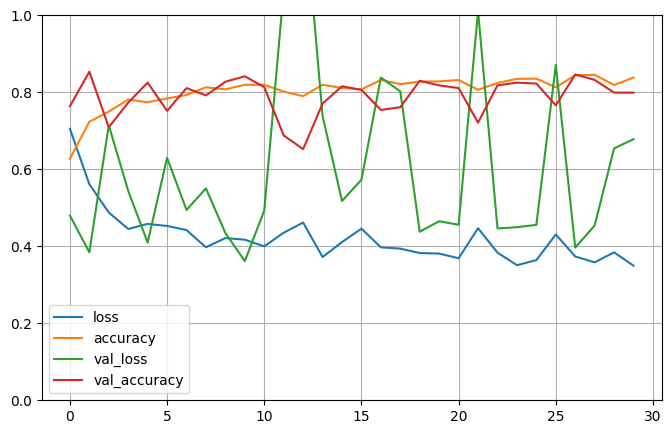

In [ ]:
#show learning curves
#mean training loss and accuracy measured over each epoch
#mean validation loss and accuracy measured at the end of each epoch
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # set the vertical range to [0-1]
plt.show()

In [ ]:
model.save('model/dataset45_30.h5')

In [ ]:
loss,accuracy = model.evaluate(test_set)
print("loss:",loss)
print("Accuracy:",accuracy)

14/14 [==============================] - 38s 3s/step - loss: 0.6782 - accuracy: 0.7991
loss: 0.6782020926475525
Accuracy: 0.7990543842315674


In [ ]:
y_pred = np.argmax(model.predict(test_set),axis=1)

14/14 [==============================] - 30s 2s/step


In [ ]:
# create another generator for all test images in a single batch
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = test_datagen.flow_from_directory(
        "LATEST/dataset/Split/TEST/",
        target_size=(224,224),
        batch_size=750)

Found 423 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import accuracy_score
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

14/14 [==============================] - 33s 2s/step
Accuracy score: 79.9%


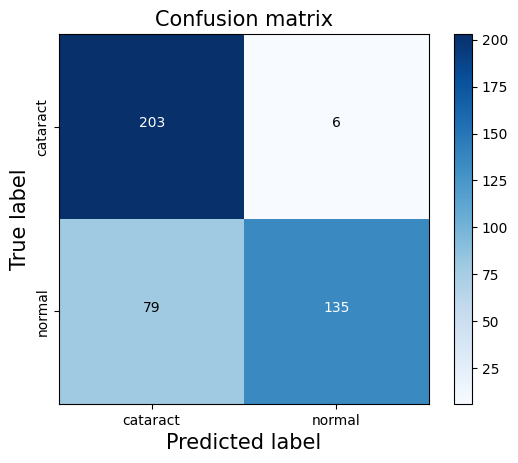

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes = ['cataract','normal']
    plt.xticks([0,1], classes, fontsize=10)
    plt.yticks([0,1], classes, fontsize=10,rotation=90,verticalalignment="center")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=15)
    plt.ylabel('True label',fontsize=15)

plot_confusion_matrix(confusion_matrix(y_label,y_pred))

In [ ]:
print(classification_report(y_test, y_pred))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets